# Selección de portafolio - Markowitz


En este notebook, exploraremos la teoría del portafolio moderna utilizando Python.

La teoría del portafolio moderna, desarrollada por Harry Markowitz en 1952, (artículo completo disponible en [este link](https://www.math.hkust.edu.hk/~maykwok/courses/ma362/07F/markowitz_JF.pdf)) busca optimizar la selección de activos en un portafolio de inversiones al encontrar la combinación de activos que maximiza el rendimiento esperado para un nivel de riesgo dado o, alternativamente, minimiza el riesgo para un rendimiento esperado dado.

La idea central es que la diversificación permite a los inversores reducir el riesgo de su portafolio sin sacrificar el rendimiento esperado.


La TPM asume que los inversionistas son aversos al riesgo, lo que significa que, dadas dos carteras que ofrecen el mismo rendimiento esperado, los inversionistas preferirán la menos riesgosa. Por lo tanto, un inversionista asumirá un mayor riesgo solo si se le compensa con rendimientos esperados más altos. Por el contrario, un inversionista que busca rendimientos esperados más altos debe aceptar más riesgo.


La implicación es que un inversionista racional no invertirá en un portafolio si existe un segundo portafolio que para ese mismo nivel de riesgo tiene mejores rendimientos esperados.


In [1]:
# Importar bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime

## Obtención de datos de precios de acciones

Primero, seleccionaremos algunos símbolos de acciones para construir nuestro portafolio. En este ejemplo, utilizaremos acciones de Apple (AAPL), Microsoft (MSFT), Amazon (AMZN) y Google (GOOGL). Luego, obtendremos los datos de precios ajustados al cierre de estas acciones utilizando la biblioteca `yfinance`.


In [2]:
# Configurar las fechas de inicio y fin de los datos históricos
start_date = datetime.datetime(2019, 1, 1)
end_date = datetime.datetime.now()

# Listar algunos tickers de acciones para construir el portafolio
# ejemplo: Apple, Microsoft, Amazon y Google
symbols = ['AAPL', 'MSFT', 'AMZN', 'GOOGL']

# Descargar datos de precios ajustados al cierre de las acciones seleccionadas
data = yf.download(symbols, start=start_date, end=end_date)['Adj Close']

[*********************100%%**********************]  4 of 4 completed


In [3]:
data.head()

Ticker,AAPL,AMZN,GOOGL,MSFT
Date,,,,
2019-01-02,37.845043,76.956497,52.734001,95.846024
2019-01-03,34.075394,75.014000,51.273499,92.320030
2019-01-04,35.530045,78.769501,53.903500,96.613777
2019-01-07,35.450966,81.475502,53.796001,96.736984
2019-01-08,36.126774,82.829002,54.268501,97.438400


## Calcular rendimientos diarios y estadísticas de portafolio

Ahora calcularemos los rendimientos diarios de las acciones y luego utilizaremos estos rendimientos para calcular los rendimientos anuales esperados y la matriz de covarianza.

Estos son elementos clave para aplicar la teoría del portafolio moderno.


In [4]:
# Calcular los rendimientos diarios de las acciones
daily_returns = data.pct_change().dropna()
daily_returns.head()

Ticker,AAPL,AMZN,GOOGL,MSFT
Date,,,,
2019-01-03,-0.099607,-0.025241,-0.027696,-0.036788
2019-01-04,0.042689,0.050064,0.051294,0.046509
2019-01-07,-0.002226,0.034353,-0.001994,0.001275
2019-01-08,0.019063,0.016612,0.008783,0.007251
2019-01-09,0.016982,0.001714,-0.003427,0.014300


Calcular los rendimientos anuales esperados y la matriz de covarianza

El número 252 representa la cantidad típica de días hábiles en un año en los mercados financieros de EE. UU. La operación

```
(1 + daily_returns.mean())**252 - 1  
```

 convierte el rendimiento promedio diario en un rendimiento anualizado.

 La idea detrás de esta conversión es proyectar cómo se comportarían los rendimientos si los rendimientos promedio diarios se mantuvieran constantes a lo largo de un año completo de negociación.


`daily_returns.cov()` calcula la matriz de covarianza de los rendimientos diarios de las acciones. La covarianza es una medida estadística que indica cómo dos variables se mueven juntas. En este caso, nos interesa saber cómo los rendimientos de las acciones en el portafolio se mueven juntos. Si la covarianza entre dos acciones es positiva, significa que tienden a moverse en la misma dirección, mientras que si es negativa, tienden a moverse en direcciones opuestas. Una covarianza cercana a cero indica que no hay una relación clara entre los movimientos de las dos acciones.

Para convertir la matriz de covarianza diaria en anual, simplemente multiplicamos por la cantidad de días de negociación en un año (252). Esta conversión es válida y se basa en el supuesto de que los rendimientos diarios son independientes y siguen una distribución normal. Bajo este supuesto, la varianza y la covarianza se pueden escalar linealmente con el tiempo.

In [5]:
# Calcular los rendimientos anuales esperados y la matriz de covarianza
annual_expected_returns = (1 + daily_returns.mean())**252 - 1
covariance_matrix = daily_returns.cov() * 252

In [6]:
annual_expected_returns

Ticker
AAPL     0.433548
AMZN     0.241433
GOOGL    0.277684
MSFT     0.388478
dtype: float64

In [7]:
covariance_matrix.head()

Ticker,AAPL,AMZN,GOOGL,MSFT
Ticker,,,,
AAPL,0.102407,0.069134,0.068306,0.073198
AMZN,0.069134,0.123396,0.073311,0.072633
GOOGL,0.068306,0.073311,0.100664,0.072793
MSFT,0.073198,0.072633,0.072793,0.091553


## Generar portafolios aleatorios

Generaremos un gran número de portafolios aleatorios utilizando diferentes combinaciones de pesos para las acciones seleccionadas. Para cada portafolio, calcularemos el rendimiento esperado y la volatilidad (desviación estándar) del portafolio. Luego, graficaremos estos portafolios en un gráfico de rendimiento esperado frente a volatilidad para visualizar la frontera eficiente.


Explicación detallada:
`num_portfolios` Esta línea establece el número de portafolios aleatorios que se generarán. En este caso, se generarán 5,000 portafolios aleatorios con diferentes combinaciones de ponderaciones para las acciones en el portafolio. Aumentar el número de portafolios generados permite explorar un espacio más amplio de posibles combinaciones de ponderaciones, lo que podría ayudar a encontrar un portafolio óptimo más preciso. Sin embargo, también puede aumentar el tiempo de cálculo.

`weights_arr = np.zeros((num_portfolios, len(symbols)))` Esta línea crea una matriz de ceros con num_portfolios filas y len(symbols) columnas. Cada fila de la matriz representará un portafolio aleatorio, y cada columna representará el peso de una acción en el portafolio. La matriz se llenará con los pesos generados aleatoriamente para cada portafolio en el bucle que sigue.

`returns_arr = np.zeros(num_portfolios)` Esta línea crea un array de ceros con una longitud igual a num_portfolios. Este array se utilizará para almacenar el rendimiento esperado de cada portafolio aleatorio generado. Para cada portafolio, se calculará su rendimiento esperado en función de los pesos y los rendimientos anuales esperados de las acciones y se almacenará en este array.

`volatility_arr = np.zeros(num_portfolios)` Esta línea crea un array de ceros con una longitud igual a num_portfolios. Este array se utilizará para almacenar la volatilidad (desviación estándar) de cada portafolio aleatorio generado. Para cada portafolio, se calculará su volatilidad en función de los pesos y la matriz de covarianza anualizada de las acciones y se almacenará en este array.

Estas estructuras de datos almacenarán los pesos, los rendimientos esperados y las volatilidades de los portafolios generados, lo que permitirá identificar y seleccionar el portafolio óptimo según los criterios deseados (por ejemplo, maximizar el índice de Sharpe).

In [8]:
# Generar un gran número de portafolios aleatorios
num_portfolios = 5000 # numero de portafolios
weights_arr = np.zeros((num_portfolios, len(symbols)))
returns_arr = np.zeros(num_portfolios)
volatility_arr = np.zeros(num_portfolios)

El siguiente bloque genera los pesos, rendimientos y volatilidades de los n portafolios generados.

Respecto a :
`portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))`

Esta línea de código calcula la volatilidad (desviación estándar) del portafolio en función de los pesos de las acciones en el portafolio y la matriz de covarianza anualizada de los rendimientos de las acciones.

La fórmula para calcular la volatilidad del portafolio es:

`portfolio_volatility = sqrt(weights^T * covariance_matrix * weights)`

Donde:

- weights es un vector columna que contiene los pesos de las acciones en el portafolio.
- covariance_matrix es la matriz de covarianza anualizada de los rendimientos de las acciones.
- weights^T es la transpuesta del vector de pesos.

Explicación de la línea de código:

`np.dot(covariance_matrix, weights)`: Esta operación realiza la multiplicación matricial entre la matriz de covarianza y el vector de pesos. El resultado es un vector columna.

`np.dot(weights.T, ...)`: Esta operación realiza la multiplicación matricial entre la transpuesta del vector de pesos y el vector columna resultado del paso anterior. El resultado es un escalar que representa la varianza del portafolio.

`np.sqrt(...)`: Finalmente, aplicamos la raíz cuadrada al escalar resultante para obtener la volatilidad (desviación estándar) del portafolio.

In [9]:
weights = np.random.random(len(symbols))
print(weights)
print(weights / np.sum(weights))

[0.42396152 0.32573895 0.38551778 0.91687097]
[0.20659994 0.15873528 0.18786599 0.44679878]


In [10]:
for i in range(num_portfolios):
    # Generar pesos aleatorios y normalizarlos para que sumen 1
    weights = np.random.random(len(symbols))
    weights = weights / np.sum(weights)

    # Calcular el rendimiento y la volatilidad esperados del portafolio
    portfolio_return = np.dot(weights, annual_expected_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))

    # Almacenar los resultados en los arrays correspondientes
    weights_arr[i, :] = weights #pesos generados del port. i
    returns_arr[i] = portfolio_return #rendimientos generados port. i
    volatility_arr[i] = portfolio_volatility #volatilidad gen. port. i

# Crear un DataFrame con los resultados de los portafolios
portfolios = pd.DataFrame({'Volatility': volatility_arr, 'Return': returns_arr})
for i, symbol in enumerate(symbols):
    portfolios[symbol + ' Weight'] = weights_arr[:, i]
portfolios.head()

,Volatility,Return,AAPL Weight,MSFT Weight,AMZN Weight,GOOGL Weight
0,0.286654,0.306698,0.098670,0.304955,0.373529,0.222846
1,0.281400,0.345647,0.259066,0.187372,0.243289,0.310273
2,0.284594,0.349947,0.438468,0.195314,0.266919,0.099299
3,0.285909,0.366727,0.473590,0.212697,0.106681,0.207033
4,0.297760,0.289051,0.024919,0.516130,0.222533,0.236418


In [11]:
portfolios.shape

(5000, 6)

## Graficar la frontera eficiente

Ahora que hemos generado una serie de portafolios aleatorios, podemos graficarlos en un gráfico de rendimiento esperado frente a volatilidad. Esto nos permite visualizar la frontera eficiente, que es el conjunto de portafolios que ofrecen la máxima rentabilidad posible para un nivel de riesgo dado.


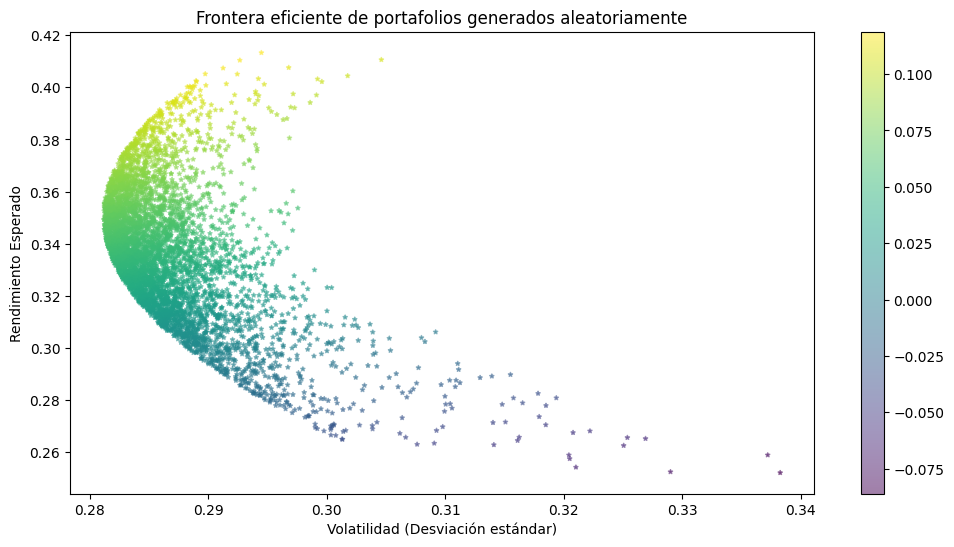

In [12]:
# Graficar la frontera eficiente de los portafolios generados
plt.figure(figsize=(12, 6))
plt.scatter(portfolios['Volatility'], portfolios['Return'], c=(portfolios['Return'] - portfolios['Volatility']), cmap='viridis', marker='*', s=10, alpha=0.5)
plt.colorbar(label='')
plt.xlabel('Volatilidad (Desviación estándar)')
plt.ylabel('Rendimiento Esperado')
plt.title('Frontera eficiente de portafolios generados aleatoriamente')
plt.grid(False)
plt.show()


## Encontrar el portafolio que maximiza el ratio de sharpe



In [22]:
# Agregar el ratio de sharpe
portfolios['ratio_sharpe'] = (portfolios['Return']-0.03)/portfolios['Volatility']

# Ponderaciones del portafolio de mínima varianza
portfolios[portfolios['Volatility'] == portfolios['Volatility'].min()]

,Volatility,Return,AAPL Weight,MSFT Weight,AMZN Weight,GOOGL Weight,ratio_sharpe
365,0.281193,0.349255,0.254592,0.152086,0.255733,0.337589,1.13536


In [23]:
# Ponderaciones del portafolio óptimo media-varianza
portfolios[portfolios['ratio_sharpe'] == portfolios['ratio_sharpe'].max()]

,Volatility,Return,AAPL Weight,MSFT Weight,AMZN Weight,GOOGL Weight,ratio_sharpe
1300,0.294486,0.413274,0.6289,0.007064,0.022649,0.341387,1.301503


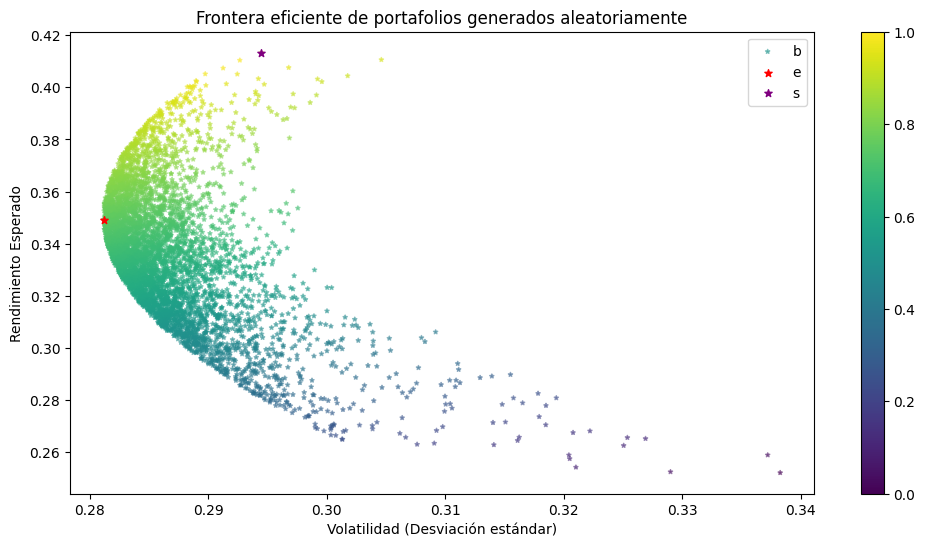

In [29]:
# Graficar la frontera eficiente de los portafolios generados, el de minima varianza y el portafolio eficiente
rend_minvar = portfolios[portfolios['Volatility'] == portfolios['Volatility'].min()]['Return']
std_minvar = portfolios[portfolios['Volatility'] == portfolios['Volatility'].min()]['Volatility']

rend_opt = portfolios[portfolios['ratio_sharpe'] == portfolios['ratio_sharpe'].max()]['Return']
std_opt = portfolios[portfolios['ratio_sharpe'] == portfolios['ratio_sharpe'].max()]['Volatility']


plt.figure(figsize=(12, 6))
plt.scatter(portfolios['Volatility'], portfolios['Return'], c=(portfolios['Return'] - portfolios['Volatility']), cmap='viridis', marker='*', s=10, alpha=0.5)
plt.scatter(x = std_minvar, y= rend_minvar,  c='r', marker='*', s=30, label='Min_Var')
plt.scatter(x = std_opt, y= rend_opt,  c='purple', marker='*', s=30, label='Optimo')
plt.colorbar(label='')
plt.xlabel('Volatilidad (Desviación estándar)')
plt.ylabel('Rendimiento Esperado')
plt.title('Frontera eficiente de portafolios generados aleatoriamente')
plt.grid(False)
plt.show()